
MMDetection tutorial을 활용하여 베이스라인을 만들었습니다.

coco format으로 변환하는 부분은 이여름님께서 공유해주신 [코드](https://dacon.io/competitions/official/235855/codeshare/3729)를 참고했고

데이터 정제 과정과 추론 부분은 데이콘에서 제공해 주신 [베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)을 참고했습니다.


**참고 링크** <p>
- [이여름님의 코드](https://dacon.io/competitions/official/235855/codeshare/3729)
- [데이콘 베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)
- [colab version tutorial](https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb)
- [kaggle notebook](https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21)


**MMDetection 관련 링크**
- [mmdetection github](https://github.com/open-mmlab/mmdetection)
- [mmdetection docs](https://mmdetection.readthedocs.io/)
- [model_zoo](https://mmdetection.readthedocs.io/en/latest/model_zoo.html#baselines)

*❗❗* 코드는 모든 학습 데이터를 사용할 수 있도록 해놓았지만 출력은 일부 데이터만 사용한 결과물이며 로컬 환경과 코랩 환경을 오가며 진행했습니다.

## Prepare data

conda install pytorch==1.10.0 torchvision==0.11.0 torchaudio==0.10.0 cudatoolkit=11.3 -c pytorch -c conda-forge

pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.10.0/index.html

git clone https://github.com/open-mmlab/mmdetection.git

pip install -r requirements/build.txt

pip install pycocotools-windows

pip install -v -e .





In [1]:
# basic setup
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime
import os
import zipfile
import random
from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
from glob import glob

from collections import defaultdict

base_dir = "/content/project/input"


In [2]:
os.makedirs('./project/input', exist_ok=True)
os.makedirs('./project/output', exist_ok=True)
%cd project

/content/project


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
with zipfile.ZipFile('/content/drive/MyDrive/project/vinBigData/Chest X-ray(512).zip', 'r') as zip_ref:
  zip_ref.extractall('/content/project/input')

In [5]:
%pwd

'/content/project'

In [6]:
df = pd.read_csv('./input/train.csv')

In [7]:
df['class_id'].unique()

array([14,  3, 10, 11,  0, 13,  5,  8,  9,  7,  6,  4,  2,  1, 12])

In [8]:
# nofinding 제거 버전
df = pd.read_csv('./input/train.csv')
df = df[df['class_id'] != 14]
df['class_id'] = df['class_id'] + 1
df = df[['image_id', 'class_id', 'x_min', 'y_min', 'x_max', 'y_max']]
df

,image_id,class_id,x_min,y_min,x_max,y_max
6,9a5094b2563a1ef3ff50dc5c7ff71345,4,170.092308,301.369863,406.892308,401.315068
7,9a5094b2563a1ef3ff50dc5c7ff71345,11,440.369231,378.958904,461.538462,436.602740
8,9a5094b2563a1ef3ff50dc5c7ff71345,12,440.369231,378.958904,461.538462,436.602740
9,9a5094b2563a1ef3ff50dc5c7ff71345,4,170.338462,301.369863,407.876923,394.301370
10,9a5094b2563a1ef3ff50dc5c7ff71345,4,169.600000,287.780822,410.092308,386.410959
...,...,...,...,...,...,...
67774,52951d7de2485aba8ed62629eee4d254,10,67.333333,256.355556,85.111111,268.088889
67775,52951d7de2485aba8ed62629eee4d254,4,163.111111,279.288889,358.666667,336.355556
67848,1224f07d895107573588225f692e94f9,1,250.729412,161.922261,320.250980,223.434629
67849,1224f07d895107573588225f692e94f9,1,262.525490,155.590106,319.247059,221.399293


In [9]:
print("df Shape: "+str(df.shape))
print("No Of Classes: "+str(df["class_id"].nunique()))
df.sort_values(by='image_id').head(10)
len(df)


df Shape: (36096, 6)
No Of Classes: 14


36096

In [10]:
def convert_to_coco(name_list, df, save_path): # 변경

  res = defaultdict(list)
    
  categories = {
      'Aortic enlargement': 1,
      'Atelectasis': 2,
      'Calcification': 3,
      'Cardiomegaly': 4,
      'Consolidation': 5,
      'ILD': 6,
      'Infiltration': 7,
      'Lung Opacity': 8,
      'Nodule/Mass': 9,
      'Other lesion': 10,
      'Pleural effusion': 11,
      'Pleural thickening': 12,
      'Pneumothorax': 13,
      'Pulmonary fibrosis': 14
  }
    
  df = df[df['image_id'].isin(name_list)]
  names = df['image_id'].unique()
  n_id = 0

  for pic_name in tqdm(names):

    df_temp = df[df['image_id'] == pic_name]
    tmp = df_temp.values

    res['images'].append({
        'id': pic_name,
        'width': 512,
        'height':512,
        'file_name': pic_name+".png"
    })
      
    for shape in tmp:
        x1, y1, x2, y2 = shape[2], shape[3], shape[4], shape[5]
        
        w, h = x2 - x1, y2 - y1
        
        res['annotations'].append({
            'id': n_id,
            'image_id': pic_name,
            'category_id': shape[1],
            'area': w * h,
            'bbox': [x1, y1, w, h],
            'iscrowd': 0,
        })
        n_id += 1
    
  for name, id in categories.items():
      res['categories'].append({
          'id': id,
          'name': name,
      })
  # return res
  with open(save_path, 'w') as f:
      json.dump(res, f)

In [11]:
random.seed(10)

train_files = df['image_id'].unique()

random.shuffle(train_files)

# 8:2로 학습/검증 데이터 분리
split_num = int(len(train_files)*0.2)
print("split_num :", split_num)

train_file = train_files[split_num:]
valid_file = train_files[:split_num]

len(train_file), len(valid_file),len(train_files)

split_num : 878


(3516, 878, 4394)

In [12]:
convert_to_coco(train_file, df, os.path.join(base_dir, 'train_annotations.json'))

  0%|          | 0/3516 [00:00<?, ?it/s]

In [13]:
convert_to_coco(valid_file, df, os.path.join(base_dir, 'valid_annotations.json'))

  0%|          | 0/878 [00:00<?, ?it/s]

## Environment setting

In [14]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

!pip show torch

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Name: torch
Version: 1.12.1+cu113
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchaudio, fastai


런타임 다시 시작하고 진행합니다.

In [15]:
!git clone https://github.com/open-mmlab/mmdetection.git

Cloning into 'mmdetection'...
remote: Enumerating objects: 32083, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 32083 (delta 70), reused 99 (delta 26), pack-reused 31875
Receiving objects: 100% (32083/32083), 41.06 MiB | 17.50 MiB/s, done.
Resolving deltas: 100% (23046/23046), done.


In [16]:
%cd ./mmdetection

/content/project/mmdetection


In [17]:
!pip install openmim
!mim install mmdet==2.22.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 237 kB 67.6 MB/s 
     |████████████████████████████████| 51 kB 8.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 1.3 MB 31.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 728 kB 30.9 MB/s 
Saved /tmp/tmpgok4qde6/mmdet-2.22.0.tar.gz
Successfully downloaded mmdet
Get 'mim' extra requirements from `mminstall.txt` for mmdet 2.22.0: ['mmcv-full>=1.3.17'].
     |████████████████████████████████| 40.6 MB 1.4 MB/s 
     |████████████████████████████████| 190 kB 86.9 MB/s 
Using cached `mminstall.txt` for mmdet==2.22.0: /

=========

In [18]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.12.1+cu113 True
2.25.2
11.3
GCC 9.3


In [19]:
%pwd

'/content/project/mmdetection'

In [20]:
!mkdir checkpoints

In [21]:
%cd /content/project/mmdetection/checkpoints

/content/project/mmdetection/checkpoints


In [22]:
# Download pretrain weight from mmdetection github (CenterNet R-18 and Retina ResNet-101)
!wget -c https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r101_fpn_2x_coco/retinanet_r101_fpn_2x_coco_20200131-5560aee8.pth \
      -O /content/project/mmdetection/checkpoints/retinanet_r101_fpn_2x_coco_20200131-5560aee8.pth

--2022-10-23 10:24:16--  https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r101_fpn_2x_coco/retinanet_r101_fpn_2x_coco_20200131-5560aee8.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.74.197.92
Connecting to download.openmmlab.com (download.openmmlab.com)|47.74.197.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228377233 (218M) [application/octet-stream]
Saving to: ‘/content/project/mmdetection/checkpoints/retinanet_r101_fpn_2x_coco_20200131-5560aee8.pth’

/content/project/mm 100%[===================>] 217.80M  16.8MB/s    in 14s     

2022-10-23 10:24:30 (15.8 MB/s) - ‘/content/project/mmdetection/checkpoints/retinanet_r101_fpn_2x_coco_20200131-5560aee8.pth’ saved [228377233/228377233]



In [23]:
config = "/content/project/mmdetection/configs/retinanet/retinanet_r101_fpn_2x_coco.py"
checkpoint = "/content/project/mmdetection/checkpoints/retinanet_r101_fpn_2x_coco_20200131-5560aee8.pth"

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



In [24]:
!pip install -e .


ERROR: File "setup.py" or "setup.cfg" not found. Directory cannot be installed in editable mode: /content/project/mmdetection/checkpoints


In [25]:
!pip install -qU wandb


     |████████████████████████████████| 1.9 MB 30.2 MB/s 
     |████████████████████████████████| 166 kB 79.8 MB/s 
     |████████████████████████████████| 182 kB 70.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 166 kB 72.3 MB/s 
     |████████████████████████████████| 162 kB 73.9 MB/s 
     |████████████████████████████████| 162 kB 81.8 MB/s 
     |████████████████████████████████| 158 kB 97.3 MB/s 
     |████████████████████████████████| 157 kB 95.3 MB/s 
     |████████████████████████████████| 157 kB 99.7 MB/s 
     |████████████████████████████████| 157 kB 83.0 MB/s 
     |████████████████████████████████| 157 kB 84.0 MB/s 
     |████████████████████████████████| 157 kB 82.4 MB/s 
     |████████████████████████████████| 157 kB 80.7 MB/s 
     |████████████████████████████████| 157 kB 84.9 MB/s 
     |████████████████████████████████| 156 kB 84.7 MB/s 


In [26]:
import os
import os.path as osp
import torch
import torchvision
import numpy as np

# MMDetection
import mmdet
print(mmdet.__version__)
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
from mmdet.apis import set_random_seed

# MMCV
import mmcv
from mmcv import Config

# Weights and Biases
import wandb
print(wandb.__version__)


2.25.2
0.13.4


In [27]:
wandb.login()


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [28]:
from mmcv import Config
cfg = Config.fromfile(config)

In [29]:
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='RetinaNet',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        start_level=1,
        add_extra_convs='on_input',
        num_outs=5),
    bbox_head=dict(
        type='RetinaHead',
        num_classes=80,
        in_channels=256,
        stacked_convs=4,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            octave_base_scale=4,
            scales_per_octave=3,
            ratios=[0.5, 1.0, 2.0],
            strides=[8, 16, 32, 64, 128]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [30]:
from mmdet.apis import set_random_seed

base_path = '/content/project/input' # base_dir과 같습니다.

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/project/vinBigData/retina/2'

EPOCHS= 30


In [31]:
train_anno = "train_annotations.json" # 출력은 "train_partial_annotations.json"
valid_anno = "valid_annotations.json" # 출력은 "valid_partial_annotations.json"
test_anno = "valid_annotations.json" # 출력은 "valid_partial_annotations.json"

train_img = "train" # 출력은 "train_100000"
valid_img = 'train'
test_img =  "test" # 출력은 "train_100000"



# Modify dataset type and path
cfg.dataset_type = 'CocoDataset'
cfg.data_root = base_path

#train
cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = base_path
cfg.data.train.ann_file = train_anno
cfg.data.train.img_prefix = train_img

#valid
cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = base_path
cfg.data.val.ann_file = valid_anno
cfg.data.val.img_prefix = valid_img

#test
cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = base_path
cfg.data.test.ann_file = test_anno
cfg.data.test.img_prefix = test_img



cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

classes = (
    'Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Nodule/Mass',
    'Other lesion',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis',
    )

cfg.data.train.classes = classes
cfg.data.val.classes = classes
cfg.data.test.classes = classes


# modify num classes of the model in box head
# 직접 가서 바꿈 !!!!!
cfg.model.bbox_head['num_classes'] = 14
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch

cfg.load_from = checkpoint
#resume-from : weight와 optimizer 상태 모두 로드 및 epoch도 지정된 checkpoint에서 상속
cfg.resume_from = None


# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer = dict(type='Adam', lr=0.0003, weight_decay=0.0001)
#cfg.optimizer.lr = 0.02 / 8 # 0.0025
# learning rate
cfg.lr_config.warmup = None

# 에폭 수 조절
cfg.runner = dict(type='EpochBasedRunner', max_epochs=EPOCHS)

cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='MMDetWandbHook',
         init_kwargs={'project': 'MMDetection-retina_2'},
         interval=10,
         log_checkpoint=True,
         log_checkpoint_metadata=True,
         num_eval_images=100)]

cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
#COCO dataset은 mmdetection에서 mAP metric을 지원하지 않아 VOC로 테스트
cfg.evaluation.metric = 'bbox'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device='cuda'


"""
cfg.model.roi_head.init_cfg =
cfg.model.rpn_head.init_cfg =
cfg.model.neck.init_cfg = dict(type='Pretrained', checkpoint='torchvision://resnet50'))
cfg.model.backbone.init_cfg = dict(type='Pretrained', checkpoint='torchvision://resnet50'))

cfg.model.backbone.frozen_stage= -1
"""


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='RetinaNet',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        start_level=1,
        add_extra_convs='on_input',
        num_outs=5),
    bbox_head=dict(
        type='RetinaHead',
        num_classes=14,
        in_channels=256,
        stacked_convs=4,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            octave_base_scale=4,
            scales_per_octave=3,
            ratios=[0.5, 1.0, 2.0],
            strides=[8, 16, 32, 64, 128]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',

In [32]:
meta = dict()
meta['exp_name'] = osp.basename(config)
print(meta)

{'exp_name': 'retinanet_r101_fpn_2x_coco.py'}


In [33]:
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='MMDetWandbHook',
         init_kwargs={'project': 'MMDetection-retina2'},
         interval=10,
         log_checkpoint=True,
         log_checkpoint_metadata=True,
         num_eval_images=10)]


### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [39]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# Build dataset
datasets = [build_dataset(cfg.data.train)]
print(datasets)

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
[
CocoDataset Train dataset with number of images 3516, and instance counts: 
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| category               | count | category                | count | category          | count | category                | count | category          | count |
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| 0 [Aortic enlargement] | 5793  | 1 [Atelectasis]         | 209   | 2 [Calcification] | 808   | 3 [Cardiomegaly]        | 4357  | 4 [Consolidation] | 441   |
| 5 [ILD]                | 806   | 6 [Infiltration]        | 1042  | 7 [Lung Opacity]  | 1980  | 8 [Nodule/Mass]         | 2058  | 9 [Other lesion]  | 1742  |
| 10 [Pleural effusion]  | 1921  | 11 [Pleur

In [40]:
# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES


In [41]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# Train
train_detector(model, datasets, cfg, distributed=False, validate=True)


2022-10-23 10:33:44,401 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-10-23 10:33:44,448 - mmdet - INFO - load checkpoint from local path: /content/project/mmdetection/checkpoints/retinanet_r101_fpn_2x_coco_20200131-5560aee8.pth


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


2022-10-23 10:33:44,660 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([126, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([126]).
2022-10-23 10:33:44,666 - mmdet - INFO - Start running, host: root@c0a25227fb88, work_dir: /content/drive/MyDrive/project/vinBigData/retina/2
2022-10-23 10:33:44,669 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) MMDetWandbHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdat

2022-10-23 10:33:53,770 - mmdet - WARNING - No meta information found in the runner. 


Exception: ignored

In [ ]:
PATH=f'/content/drive/MyDrive/project/vinBigData/retina/model/epoch_{EPOCHS}_retina.pt'
torch.save(model, PATH)

# 학습 이어서 하기

In [ ]:
# model로는 이어서 안됨, test 추론 할때 사용
# torch.save(model,'/content/drive/MyDrive/vinBigData/faster/model.pt')
# checkpoint로 이어서 가능
#resume-from : weight와 optimizer 상태 모두 로드 및 epoch도 지정된 checkpoint에서 상속
cfg.resume_from = '/content/drive/MyDrive/project/vinBigData/retina/1/epoch_19.pth'
cfg.load_from = None
EPOCHS = 20
# 에폭 수 조절
cfg.runner = dict(type='EpochBasedRunner', max_epochs=EPOCHS)


In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]
print(datasets)

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# train!!!
train_detector(model, datasets, cfg, distributed=False, validate=True)


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
[
CocoDataset Train dataset with number of images 3516, and instance counts: 
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| category               | count | category                | count | category          | count | category                | count | category          | count |
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| 0 [Aortic enlargement] | 5793  | 1 [Atelectasis]         | 209   | 2 [Calcification] | 808   | 3 [Cardiomegaly]        | 4357  | 4 [Consolidation] | 441   |
| 5 [ILD]                | 806   | 6 [Infiltration]        | 1042  | 7 [Lung Opacity]  | 1980  | 8 [Nodule/Mass]         | 2058  | 9 [Other lesion]  | 1742  |
| 10 [Pleural effusion]  | 1921  | 11 [Pleur

2022-10-23 09:30:21,613 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-10-23 09:30:21,655 - mmdet - INFO - load checkpoint from local path: /content/drive/MyDrive/project/vinBigData/retina/1/epoch_19.pth


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


2022-10-23 09:30:37,927 - mmdet - INFO - resumed epoch 19, iter 8360
2022-10-23 09:30:37,930 - mmdet - INFO - Start running, host: root@69ad7e5d4fa2, work_dir: /content/drive/MyDrive/project/vinBigData/retina/1
2022-10-23 09:30:37,931 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                    

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 8.8 task/s, elapsed: 100s, ETA:     0s

2022-10-23 09:47:44,633 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.25s).
Accumulating evaluation results...


2022-10-23 09:47:52,799 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.284
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.077
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.147
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.255
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.16s).


In [ ]:
PATH=f'/content/drive/MyDrive/project/vinBigData/retina/model/epoch_{EPOCHS}_retina.pt'
torch.save(model, PATH)

## Test the trained detector

In [ ]:
from mmdet.apis import inference_detector, show_result_pyplot

import os
from glob import glob
from tqdm.notebook import tqdm
test_img = os.path.join(base_path, "test")

test_file = glob(test_img+"/*.png")

In [ ]:
len(test_file), test_file[0]

(3000, '/content/project/input/test/b9dcec0d41bcd2acb499745d5aeeaf08.png')

In [ ]:
model = torch.load('/content/drive/MyDrive/project/vinBigData/retina/1/epoch_20.pth')

테스트 데이터 하나를 추론해봅니다.

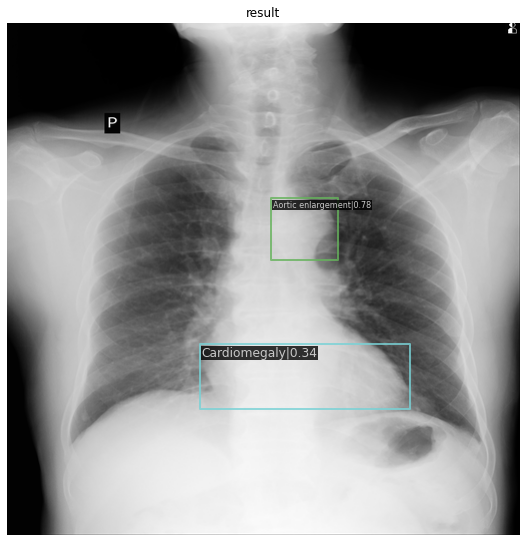

In [ ]:
img = mmcv.imread(test_file[844])

model.cfg = cfg
predictions = inference_detector(model, img)
show_result_pyplot(model, img, predictions)


In [ ]:
len(predictions), predictions[0].shape, predictions[1].shape, predictions[2].shape, predictions[3].shape,predictions[4].shape

(14, (6, 5), (0, 5), (6, 5), (3, 5), (0, 5))

In [ ]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))
        # labels scores box_xmin  box_xmax box_ymin box_ymax     
    return " ".join(pred_strings)

In [ ]:
# Ref : https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21


score_threshold = 0.5 # 0.8, 0.3, cfg.model.test_cfg.rcnn.score_thr
results = []


for index, img_path in tqdm(enumerate(test_file), total = len(test_file)):
    image_id = img_path.split("/")[-1].split(".")[0]
    file_name = img_path.split("/")[-1].split(".")[0]+".png"
    result = {
        'image_id': image_id,
        'PredictionString': '14 1.0 0 0 1 1'
    }

    img = mmcv.imread(img_path)
    predictions = inference_detector(model, img)
    boxes, scores, labels = (list(), list(), list())

    for k, cls_result in enumerate(predictions):
        # print("cls_result", cls_result)
        if cls_result.size != 0:
            if len(labels)==0:
                boxes = np.array(cls_result[:, :4])
                scores = np.array(cls_result[:, 4])
                labels = np.array([k+1]*len(cls_result[:, 4]))
            else:    
                boxes = np.concatenate((boxes, np.array(cls_result[:, :4])))
                scores = np.concatenate((scores, np.array(cls_result[:, 4])))
                labels = np.concatenate((labels, [k+1]*len(cls_result[:, 4])))

    if len(labels) != 0:
        # 라벨 -1 씩 SHIFT
        labels = labels - 1
        # no finding 이 -1에서 14로 이동!
        labels[labels == -1] = 14

        indexes = np.where(scores > score_threshold)
        # print(indexes)
        boxes = boxes[indexes]
        scores = scores[indexes]
        labels = labels[indexes]
        
        # 0.5 보다 confidence 높은 박스가 있다는 의미
        if len(boxes) > 0:
          result = {
              'image_id': image_id,
              'PredictionString': format_prediction_string(labels, boxes, scores)
          }
    # result list를 계속 append!
    results.append(result)


  0%|          | 0/3000 [00:00<?, ?it/s]

##Inference

In [ ]:
import pandas as pd
submission = pd.DataFrame(results)
submission.shape

In [ ]:
submission.head()

In [ ]:
submission.to_csv(f'/content/drive/MyDrive/project/vinBigData/submission/retina/mmdedtection_colab_retina_{EPOCHS}_1.csv', index=False)